# Making predictions over amazon recommendation dataset

## Predictions
The purpose of this analysis is to make up a prediction model where we will be able to predict whether a recommendation is positive or negative. In this analysis, we will not focus on the Score, but only the positive/negative sentiment of the recommendation. 

To do so, we will work on Amazon's recommendation dataset, we will build a Term-doc incidence matrix using term frequency and inverse document frequency ponderation. When the data is ready, we will load it into predicitve algorithms. In the end, we hope to find a "best" model for predicting the recommendation's sentiment.

## Loading the data
As we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "postive". Otherwise, it will be set to "negative". 

The data will be split into an training set and a test set with a test set ratio of 0.2

In [1]:
import pandas as pd
import numpy as np
import pickle
import string

In [2]:
df = pd.read_csv('Reviews.csv')

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.shape # data shape

(568454, 10)

In [5]:
df.nunique() # check num of unique items per column

Id                        568454
ProductId                  74258
UserId                    256059
ProfileName               218415
HelpfulnessNumerator         231
HelpfulnessDenominator       234
Score                          5
Time                        3168
Summary                   295742
Text                      393579
dtype: int64

In [6]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [7]:
# rename columns HelpfulnessNumerator and HelpfulnessDenominator
df.columns = ["Id", "ProductId", "UserId", "ProfileName", "VotesHelpful",
              "VotesTotal", "Score", "Time", "Summary", "Text"]

Let's add the **Sentiment** column that turns the numeric score into either *positive* or *negative*.

Similarly, the **Usefulness** column turns the number of votes into a boolean.

In [8]:
df["Sentiment"] = df["Score"].apply(lambda score: "positive" if score > 3 else "negative")
df.head(5)

,Id,ProductId,UserId,ProfileName,VotesHelpful,VotesTotal,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive


In [9]:
# check some statistics
print(df['Sentiment'].value_counts())

Sentiment
positive    443777
negative    124677
Name: count, dtype: int64


Select subcolumns

In [10]:
df = df[["Score", "Sentiment", "Summary", "Text"]]

Let's have a look at some 5s:

In [11]:
df[df.Score == 5].head(10)

,Score,Sentiment,Summary,Text
0,5,positive,Good Quality Dog Food,I have bought several of the Vitality canned d...
4,5,positive,Great taffy,Great taffy at a great price. There was a wid...
6,5,positive,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,5,positive,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,5,positive,Yay Barley,Right now I'm mostly just sprouting this so my...
9,5,positive,Healthy Dog Food,This is a very healthy dog food. Good for thei...
10,5,positive,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
11,5,positive,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...
14,5,positive,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...
15,5,positive,"Lots of twizzlers, just what you expect.",My daughter loves twizzlers and this shipment ...


And some 1s as well:

In [12]:
df[df.Score == 1].head(10)

,Score,Sentiment,Summary,Text
1,1,negative,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
12,1,negative,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...
26,1,negative,Nasty No flavor,"The candy is just red , No flavor . Just plan..."
50,1,negative,Don't like it,"This oatmeal is not good. Its mushy, soft, I d..."
62,1,negative,stale product.,Arrived in 6 days and were so stale i could no...
73,1,negative,Warning! WARNING! -ALCOHOL SUGARS!,Buyer Beware Please! This sweetener is not for...
75,1,negative,No Tea Flavor,No tea flavor at all. Just whole brunch of art...
99,1,negative,Bad,I fed this to my Golden Retriever and he hated...
153,1,negative,Rip off Price,These singles sell for $2.50 - $3.36 at the st...
164,1,negative,Tasteless but low calorie,Seriously this product was as tasteless as the...


## Data Cleaning:
Python package：import nltk

Stopwords removal: words like ‘the’, ‘a’, ‘me’.... could be removed, since theydon’t reflect any sentiment indication

Stemming: words will be transform to its stem, eg, tasty -> tasti, no specific
meaning, just a protocal to process the text

punctuation removal: mostly, punctuation like, ‘,’, ‘.’, ‘?’, ‘!’ are all removed. However, currently some emoji symbols are also encoded as text in order toget abetter understanding of the sentiment. But, this is NOT required

In [28]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def clean_review(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize
    words = text.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words]
    
    # Join back to string
    return ' '.join(stemmed_words)

In [29]:
# 清理 summary 为空的行（防止报错）
df = df.dropna(subset=['Summary'])

# 应用清洗函数
df['Cleaned_Summary'] = df['Summary'].apply(clean_review)

# 查看效果
df[['Summary', 'Cleaned_Summary']].head()

,Summary,Cleaned_Summary
0,Good Quality Dog Food,good qualiti dog food
1,Not as Advertised,advertis
2,"""Delight"" says it all",delight say
3,Cough Medicine,cough medicin
4,Great taffy,great taffi


## Feature Engineering
Python package：
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
Text to Vector

1) unigram: one word is taken as an input

2) Bigram: two words together are taken as one input

3) TFIDF:
https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in- python-on-real-world-dataset-796d339a4089#:~:text=TFIDF%20stands%20for%20%E2%80%9CTerm,Information%20Retrieval%20and%20Text%20Mining. 

4) Word2Vector Embedding

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
texts = df['Cleaned_Summary']

# 初始化 TF-IDF 向量器，包含 unigram 和 bigram
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_features=5000)

# 拟合并转换文本为特征向量
X = vectorizer.fit_transform(texts)

# 显示形状：行数 = 样本数，列数 = 特征词个数
print("TF-IDF 特征矩阵维度:", X.shape)


TF-IDF 特征矩阵维度: (568427, 5000)


In [32]:
# 把标签提取出来作为 y
y = df['Sentiment']  # 已经是 'positive' 或 'negative'

## Model Building

Goal: Predict whether a review summary is positive or negative based on the score (Score > 3 → positive).
This is a classification problem.

Python package：

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier


## Logistic Regresssion Model

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 划分训练集和测试集（80/20）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化并训练模型
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# 预测
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]  # positive 类的概率


## Logistic Regression Evaluation

 Logistic Regression – Evaluation Summary
✔Strengths:

Excellent at detecting positive reviews:

Precision = 0.88, Recall = 0.96, F1-score = 0.92.

Fast to train and easy to interpret.

Great for identifying the most influential words (feature coefficients).

Weaknesses:

Weak at detecting negative reviews:

Recall = 0.54 → misses nearly half of the negative samples.

Biased toward the majority class (positive reviews) due to class imbalance.

Linear model may not capture complex word interactions.

Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.54      0.64     24735
    positive       0.88      0.96      0.92     88951

    accuracy                           0.87    113686
   macro avg       0.84      0.75      0.78    113686
weighted avg       0.86      0.87      0.86    113686


 AUC Score: 0.9002


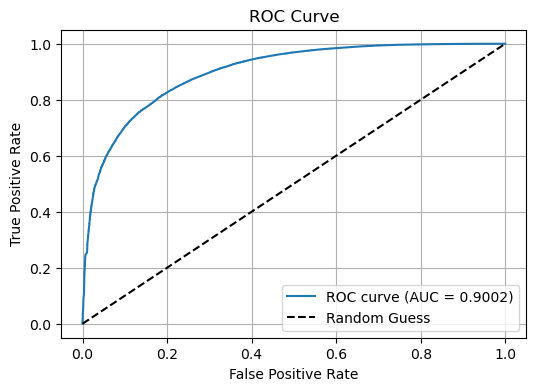

In [34]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 分类报告
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))

# AUC
auc_score = roc_auc_score((y_test == 'positive'), y_proba)
print(f"\n AUC Score: {auc_score:.4f}")

# ROC 曲线
fpr, tpr, thresholds = roc_curve((y_test == 'positive'), y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

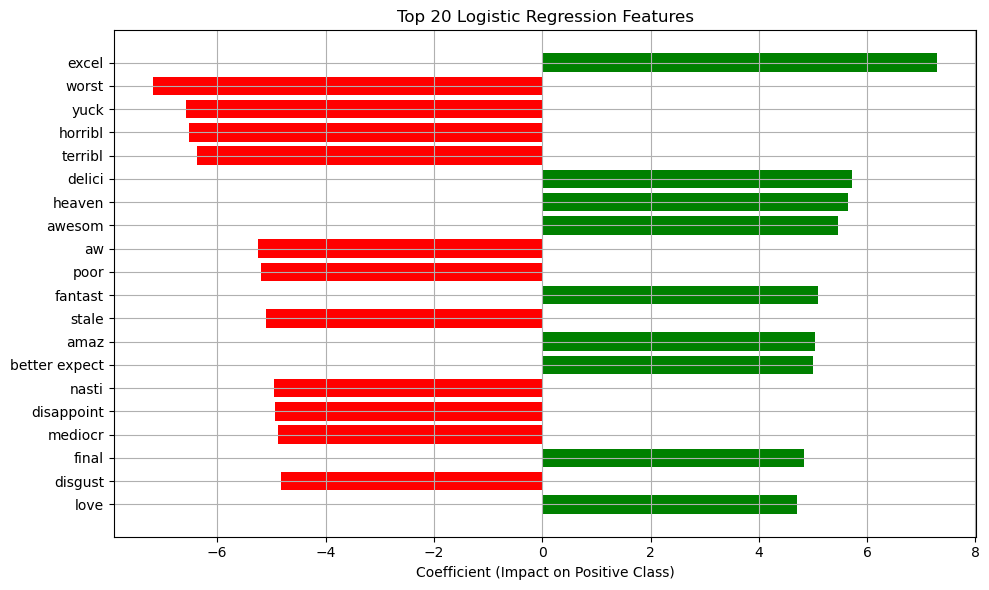

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# 获取 TF-IDF 特征名称
feature_names = vectorizer.get_feature_names_out()
coefficients = clf.coef_[0]  # shape: (1, n_features)

# 按绝对值排序，取最有影响力的 20 个
top_idx = np.argsort(np.abs(coefficients))[-20:]
top_features = feature_names[top_idx]
top_weights = coefficients[top_idx]

# 可视化
plt.figure(figsize=(10, 6))
colors = ['green' if w > 0 else 'red' for w in top_weights]
plt.barh(top_features, top_weights, color=colors)
plt.title("Top 20 Logistic Regression Features")
plt.xlabel("Coefficient (Impact on Positive Class)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Random Forest Model


In [36]:
from sklearn.ensemble import RandomForestClassifier

# 初始化并训练模型
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# 预测
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]


## Random Forest Evaluation

Strengths:

More balanced performance across both classes:

Negative class: Recall = 0.66, F1 = 0.73

Positive class: Recall = 0.96, F1 = 0.93

Better at identifying negative reviews compared to Logistic Regression.

Can model nonlinear relationships and complex interactions between words.

Weaknesses:

Slower training and prediction time, especially on large, sparse TF-IDF data.

Less interpretable than logistic regression.

Performance may vary with hyperparameters (e.g., number of trees, depth).

 Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.66      0.73     24735
    positive       0.91      0.96      0.93     88951

    accuracy                           0.89    113686
   macro avg       0.87      0.81      0.83    113686
weighted avg       0.89      0.89      0.89    113686


 AUC Score: 0.9278


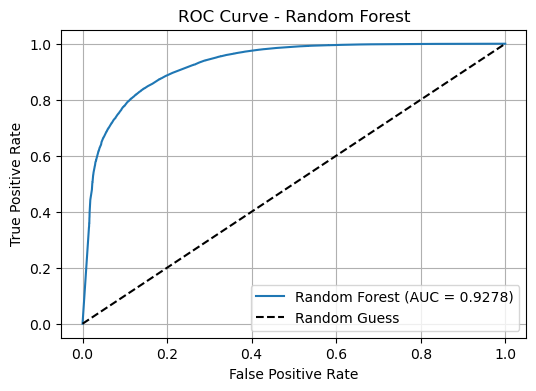

In [37]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 打印分类报告
print(" Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# AUC 分数
auc_rf = roc_auc_score((y_test == 'positive'), y_proba_rf)
print(f"\n AUC Score: {auc_rf:.4f}")

# 绘制 ROC 曲线
fpr_rf, tpr_rf, _ = roc_curve((y_test == 'positive'), y_proba_rf)
plt.figure(figsize=(6, 4))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid()
plt.show()


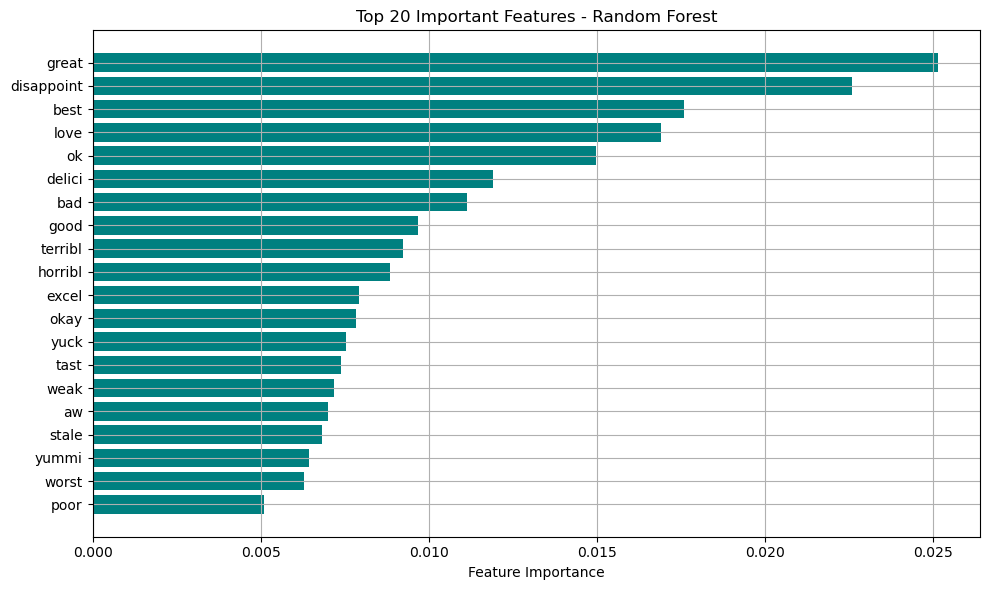

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# 获取特征名（词或词组）
feature_names = vectorizer.get_feature_names_out()

# 获取特征重要性分数
importances = rf.feature_importances_

# 获取重要性最高的前20个索引
top_idx = np.argsort(importances)[-20:]
top_features = feature_names[top_idx]
top_importances = importances[top_idx]

# 可视化
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances, color='teal')
plt.xlabel("Feature Importance")
plt.title("Top 20 Important Features - Random Forest")
plt.grid(True)
plt.tight_layout()
plt.show()


## Insights from the Random Forest Model
1. Strong Predictive Accuracy
Overall accuracy: ~89%

Positive reviews (majority class):

Precision: 0.91

Recall: 0.96
→ The model is very effective at recognizing satisfied customers.

Negative reviews (minority class):

Precision: 0.82

Recall: 0.66
→ It correctly catches a majority of complaints, though some are still missed.

2. Feature Importance Highlights Customer Language
The top keywords influencing predictions reveal how customers express satisfaction or dissatisfaction.

Words like “delicious”, “love”, “terrible”, “disappointed” help Amazon understand which product aspects drive sentiment.

## Logistic Regression WordCloud

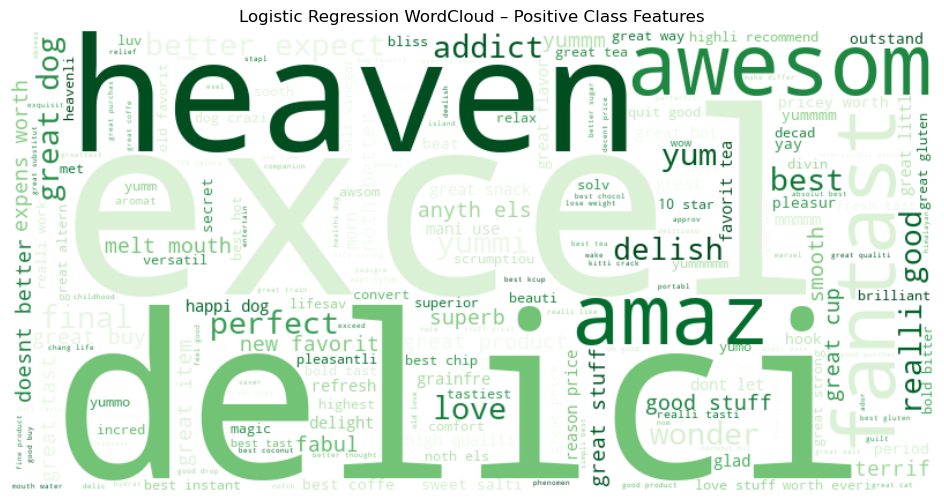

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# 获取词和对应的系数
feature_names = vectorizer.get_feature_names_out()
coefficients = clf.coef_[0]

# 只取正系数（影响 positive 预测）
positive_words = {
    feature_names[i]: coefficients[i]
    for i in range(len(coefficients))
    if coefficients[i] > 0
}

# 生成词云
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens')
wordcloud_pos.generate_from_frequencies(positive_words)

# 可视化
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.title("Logistic Regression WordCloud – Positive Class Features")
plt.show()

## Random Forest WordCloud

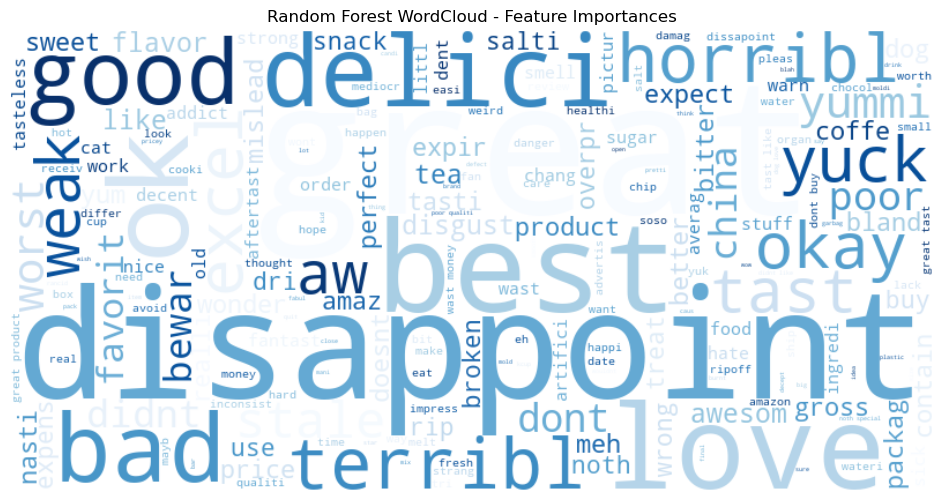

In [40]:
rf_importance_dict = dict(zip(vectorizer.get_feature_names_out(), rf.feature_importances_))

wordcloud_rf = WordCloud(width=800, height=400, background_color='white', colormap='Blues')
wordcloud_rf.generate_from_frequencies(rf_importance_dict)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_rf, interpolation='bilinear')
plt.axis("off")
plt.title("Random Forest WordCloud - Feature Importances")
plt.show()


In [41]:
import joblib

# 保存模型和向量器
joblib.dump(clf, 'logistic_regression_model.pkl')
joblib.dump(rf, 'random_forest_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']